In [1056]:
import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from IPython.display import Image
import warnings

warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

from pathlib import Path

data_folder = Path(r"C:\Users\memen\Documents\GB\GP_Python_libs\Lesson10")

In [ ]:
# def reduce_mem_usage(df):
#     """ iterate through all the columns of a dataframe and modify the data type
#         to reduce memory usage.        
#     """
#     start_mem = df.memory_usage().sum() / 1024**2
#     print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
#     for col in df.columns:
#         col_type = df[col].dtype
        
#         if col_type != object:
#             c_min = df[col].min()
#             c_max = df[col].max()
#             if str(col_type)[:3] == 'int':
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int32)
#                 elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                     df[col] = df[col].astype(np.int64)  
#             else:
#                 if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
#                     df[col] = df[col].astype(np.float32)
#                 else:
#                     df[col] = df[col].astype(np.float64)
#         else:
#             df[col] = df[col].astype('category')

#     end_mem = df.memory_usage().sum() / 1024**2
#     print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
#     print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
#     return df

In [1058]:
x_test = pd.read_csv(data_folder / 'test.csv')
x_train = pd.read_csv(data_folder / 'train.csv')
y_train = x_train.Price
x_train = x_train.drop(['Price'], axis=1)

In [1059]:
x_train['Base']=1
x_test['Base']=2

In [1060]:
all_df = pd.concat([x_train, x_test])
all_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Base
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,1
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,1


In [1061]:
y_train.head()

0    184966.930730
1    300009.450063
2    220925.908524
3    175616.227217
4    150226.531644
Name: Price, dtype: float64

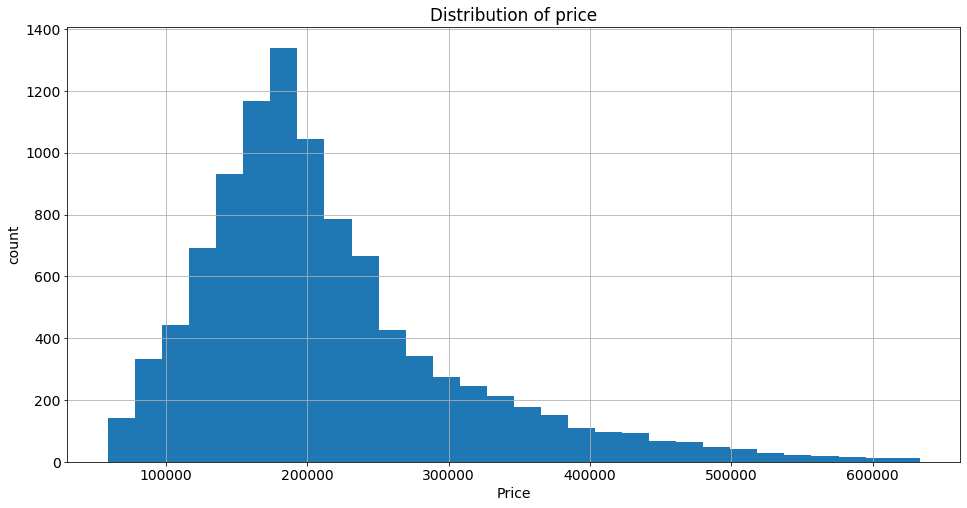

In [1062]:
plt.figure(figsize = (16, 8))

y_train.hist(bins=30)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Distribution of price')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CFA7E418C8>,
      dtype=object)

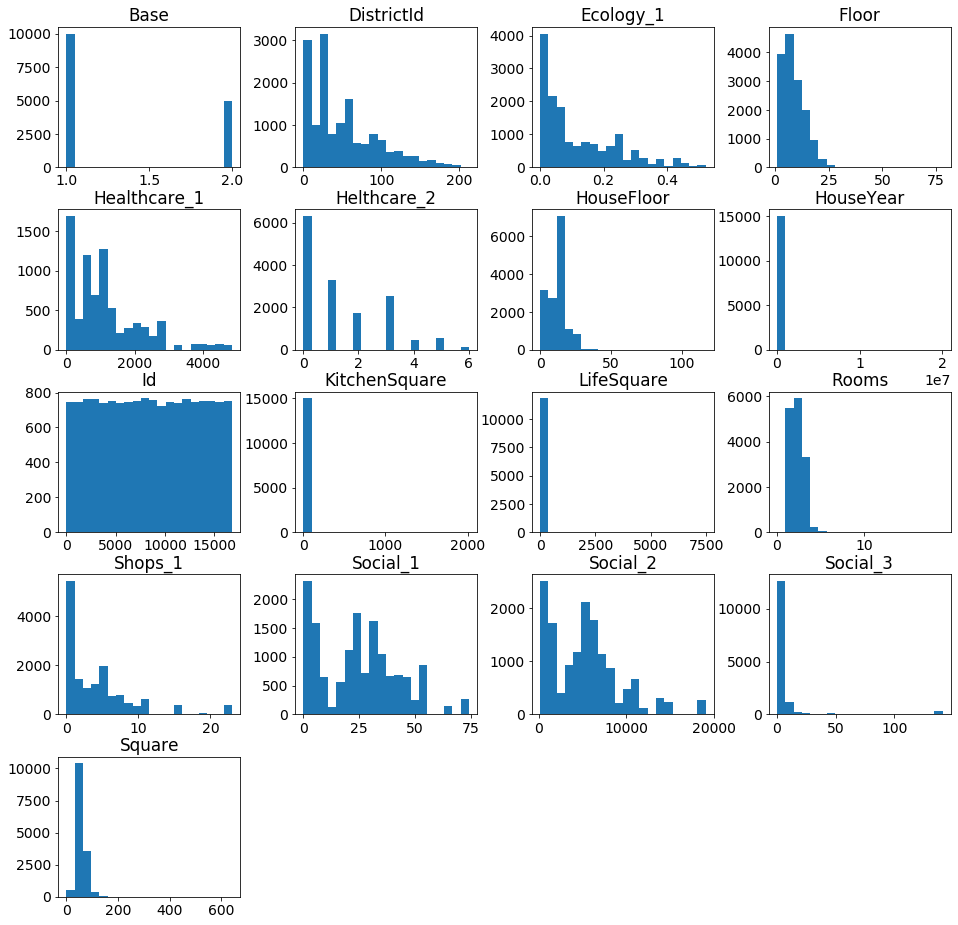

In [1063]:
df_num_features = all_df.select_dtypes(include=['float64', 'float32', 'int64', 'int32'])
df_num_features.hist(figsize=(16,16), bins=20, grid=False)

In [1064]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 4999
Data columns (total 20 columns):
Id               15000 non-null int64
DistrictId       15000 non-null int64
Rooms            15000 non-null float64
Square           15000 non-null float64
LifeSquare       11846 non-null float64
KitchenSquare    15000 non-null float64
Floor            15000 non-null int64
HouseFloor       15000 non-null float64
HouseYear        15000 non-null int64
Ecology_1        15000 non-null float64
Ecology_2        15000 non-null object
Ecology_3        15000 non-null object
Social_1         15000 non-null int64
Social_2         15000 non-null int64
Social_3         15000 non-null int64
Healthcare_1     7825 non-null float64
Helthcare_2      15000 non-null int64
Shops_1          15000 non-null int64
Shops_2          15000 non-null object
Base             15000 non-null int64
dtypes: float64(7), int64(10), object(3)
memory usage: 2.4+ MB


In [1065]:
all_df['Ecology_2'].value_counts()

B    14855
A      145
Name: Ecology_2, dtype: int64

In [1066]:
all_df['Ecology_3'].value_counts()

B    14576
A      424
Name: Ecology_3, dtype: int64

In [1067]:
all_df['Ecology_1'].value_counts()

0.007122    884
0.000000    816
0.243205    768
0.072158    714
0.075779    501
           ... 
0.059456      4
0.394094      4
0.014334      2
0.012522      1
0.005819      1
Name: Ecology_1, Length: 131, dtype: int64

In [1068]:
all_df['Shops_2'].value_counts()

B    13763
A     1237
Name: Shops_2, dtype: int64

In [1069]:
all_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       3154
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     7175
Helthcare_2         0
Shops_1             0
Shops_2             0
Base                0
dtype: int64

In [1070]:
all_df['Helthcare_2'].value_counts()

0    6310
1    3279
3    2525
2    1728
5     574
4     446
6     138
Name: Helthcare_2, dtype: int64

In [1071]:
# median0 = all_df.loc[all_df['Helthcare_2'] == 0, 'Healthcare_1'].median()
# median1 = all_df.loc[all_df['Helthcare_2'] == 1, 'Healthcare_1'].median()
# median2 = all_df.loc[all_df['Helthcare_2'] == 2, 'Healthcare_1'].median()
# median3 = all_df.loc[all_df['Helthcare_2'] == 3, 'Healthcare_1'].median()
# median4 = all_df.loc[all_df['Helthcare_2'] == 4, 'Healthcare_1'].median()
# median5 = all_df.loc[all_df['Helthcare_2'] == 5, 'Healthcare_1'].median()
# median6 = all_df.loc[all_df['Helthcare_2'] == 6, 'Healthcare_1'].median()

In [1072]:
# all_df.loc[all_df['Helthcare_2'] == 0, 'Healthcare_1'] = all_df.loc[all_df['Helthcare_2'] == 0, 'Healthcare_1'].fillna(median0)
# all_df.loc[all_df['Helthcare_2'] == 1, 'Healthcare_1'] = all_df.loc[all_df['Helthcare_2'] == 1, 'Healthcare_1'].fillna(median1)
# all_df.loc[all_df['Helthcare_2'] == 2, 'Healthcare_1'] = all_df.loc[all_df['Helthcare_2'] == 2, 'Healthcare_1'].fillna(median2)
# all_df.loc[all_df['Helthcare_2'] == 3, 'Healthcare_1'] = all_df.loc[all_df['Helthcare_2'] == 3, 'Healthcare_1'].fillna(median3)
# all_df.loc[all_df['Helthcare_2'] == 4, 'Healthcare_1'] = all_df.loc[all_df['Helthcare_2'] == 4, 'Healthcare_1'].fillna(median4)
# all_df.loc[all_df['Helthcare_2'] == 5, 'Healthcare_1'] = all_df.loc[all_df['Helthcare_2'] == 5, 'Healthcare_1'].fillna(median5)
# all_df.loc[all_df['Helthcare_2'] == 6, 'Healthcare_1'] = all_df.loc[all_df['Helthcare_2'] == 6, 'Healthcare_1'].fillna(median6)

In [1073]:
all_df['Shops_2'].value_counts()

B    13763
A     1237
Name: Shops_2, dtype: int64

In [1074]:
all_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Base
count,15000.000000,15000.000000,15000.000000,15000.000000,11846.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,8393.136933,50.693600,1.897000,56.360350,36.851792,6.174467,8.561800,12.606600,3.321575e+03,0.119196,24.769267,5370.404933,8.113667,905.061067,1.319467,4.235133,1.333333
std,4850.111673,43.786257,0.839229,20.423913,71.120183,24.016979,5.323113,6.780165,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,801.030026,1.489012,4.796545,0.471420
min,0.000000,0.000000,0.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4188.750000,20.000000,1.000000,41.814371,22.896130,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,540.000000,0.000000,1.000000,1.000000
50%,8378.500000,37.000000,2.000000,52.645757,32.822810,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,620.000000,1.000000,3.000000,1.000000
75%,12594.250000,75.000000,2.000000,66.036608,45.144624,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1084.000000,2.000000,6.000000,2.000000
max,16798.000000,212.000000,19.000000,641.065193,7480.592129,2014.000000,78.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,2.000000


In [1075]:
condition = all_df['Floor'] > all_df['HouseFloor']
all_df.loc[condition, 'HouseFloor2'] = all_df.loc[condition, 'Floor']
all_df.loc[condition, 'Floor'] = all_df.loc[condition, 'HouseFloor']
all_df.loc[condition, 'HouseFloor'] = all_df.loc[condition, 'HouseFloor2']
all_df = all_df.drop(columns=['HouseFloor2'])
all_df['HighIndex'] = round(all_df['Floor'] / all_df['HouseFloor'], 2)

In [1076]:
all_df['HouseYear'].describe()

count    1.500000e+04
mean     3.321575e+03
std      1.637078e+05
min      1.908000e+03
25%      1.974000e+03
50%      1.977000e+03
75%      2.001000e+03
max      2.005201e+07
Name: HouseYear, dtype: float64

In [1077]:
all_df.loc[all_df['HouseYear']==4968, 'HouseYear'] = 1968
all_df.loc[all_df['HouseYear']==20052011, 'HouseYear'] = 2008

In [1078]:
all_df['Ecology_2'] = all_df['Ecology_2'].apply(lambda x: 0 if x=='A' else 1)

In [1079]:
all_df['Ecology_3'] = all_df['Ecology_3'].apply(lambda x: 0 if x=='A' else 1)

In [1080]:
all_df['Ecology_23'] = all_df['Ecology_2'] + all_df['Ecology_3']

In [1081]:
all_df['Shops_2'] = all_df['Shops_2'].apply(lambda x: 0 if x=='A' else 1)

In [1082]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 4999
Data columns (total 22 columns):
Id               15000 non-null int64
DistrictId       15000 non-null int64
Rooms            15000 non-null float64
Square           15000 non-null float64
LifeSquare       11846 non-null float64
KitchenSquare    15000 non-null float64
Floor            15000 non-null float64
HouseFloor       15000 non-null float64
HouseYear        15000 non-null int64
Ecology_1        15000 non-null float64
Ecology_2        15000 non-null int64
Ecology_3        15000 non-null int64
Social_1         15000 non-null int64
Social_2         15000 non-null int64
Social_3         15000 non-null int64
Healthcare_1     15000 non-null float64
Helthcare_2      15000 non-null int64
Shops_1          15000 non-null int64
Shops_2          15000 non-null int64
Base             15000 non-null int64
HighIndex        15000 non-null float64
Ecology_23       15000 non-null int64
dtypes: float64(9), int64(13)
memory u

In [1083]:
all_df.sort_values(by='Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Base,HighIndex,Ecology_23
6392,14786,1,1.0,1.136859,4.525736,1.0,1.0,3.0,1977,0.007122,1,1,1,264,0,540.0,0,1,1,1,0.33,2
66,9011,53,1.0,1.378543,1.353573,1.0,1.0,1.0,1977,0.049637,1,1,34,7759,0,229.0,1,3,1,2,1.00,2
4902,1420,45,1.0,1.975769,2.900371,1.0,1.0,1.0,1977,0.195781,1,1,23,5212,6,1145.0,3,2,1,2,1.00,2
8283,15744,34,1.0,1.988943,2.642219,1.0,4.0,21.0,1977,0.069753,1,1,53,13670,4,620.0,1,11,1,1,0.19,2
4490,1165,27,1.0,2.372101,1.899119,1.0,2.0,17.0,1977,0.011654,1,1,4,915,0,540.0,0,0,1,2,0.12,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3217,4058,27,6.0,223.453689,104.113552,16.0,2.0,2.0,2017,0.041116,1,1,53,14892,4,620.0,1,4,1,2,1.00,2
1982,5548,86,5.0,275.645284,233.949309,26.0,12.0,37.0,2011,0.161976,1,0,31,7010,5,4508.0,3,7,1,1,0.32,1
4690,2307,102,1.0,409.425181,410.639749,10.0,4.0,4.0,2016,0.238617,1,1,26,3889,6,705.0,3,6,1,1,1.00,2
4262,28,9,2.0,604.705972,NaN,1.0,17.0,18.0,1977,0.161532,1,1,25,5648,1,30.0,2,4,1,1,0.94,2


In [1084]:
all_df.groupby("Rooms")['Square'].describe()

,count,mean,std,min,25%,50%,75%,max
Rooms,,,,,,,,
0.0,10.0,84.613222,60.024315,2.377248,43.714036,78.918300,109.558804,212.932361
1.0,5474.0,41.200432,10.919261,1.136859,36.591990,40.326570,43.570340,409.425181
2.0,5910.0,56.754185,15.054844,2.900586,47.916424,55.833543,63.526812,641.065193
3.0,3334.0,77.001488,15.811525,4.390331,66.036662,77.468118,83.122511,221.138768
4.0,240.0,96.923976,22.877790,37.920348,82.626760,97.357898,103.570014,200.334539
5.0,25.0,120.703670,48.766361,39.906082,97.537815,117.855969,124.933289,275.645284
6.0,3.0,131.206083,83.911019,59.414334,85.082280,110.750226,167.101957,223.453689
10.0,2.0,59.964120,1.282897,59.056975,59.510548,59.964120,60.417693,60.871266
17.0,1.0,52.866107,NaN,52.866107,52.866107,52.866107,52.866107,52.866107


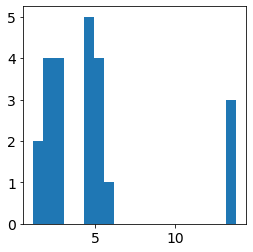

In [1085]:
all_df.loc[all_df['Square'] < 15, 'Square'].hist(figsize=(4,4), bins=20, grid=False)

In [1086]:
condition = (all_df['Square'] < 13) & (all_df['Square'] > 0.9)
all_df.loc[condition, 'Square'] = all_df.loc[condition, 'Square'].apply(lambda x: x*10)

In [1087]:
all_df.loc[all_df['Square'] < 1, 'Square'] = all_df.loc[all_df['Square'] < 1, 'Square'].apply(lambda x: x*100)

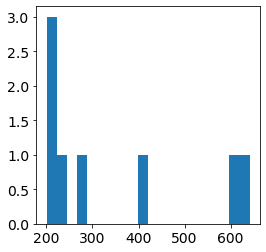

In [1088]:
all_df.loc[all_df['Square'] > 200, 'Square'].hist(figsize=(4,4), bins=20, grid=False)

In [1089]:
all_df[all_df['Square'] > 400].sort_values(by='Square', ascending=True)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Base,HighIndex,Ecology_23
4690,2307,102,1.0,409.425181,410.639749,10.0,4.0,4.0,2016,0.238617,1,1,26,3889,6,705.0,3,6,1,1,1.00,2
4262,28,9,2.0,604.705972,NaN,1.0,17.0,18.0,1977,0.161532,1,1,25,5648,1,30.0,2,4,1,1,0.94,2
6977,11602,30,2.0,641.065193,638.163193,10.0,19.0,20.0,2019,0.000078,1,1,22,6398,141,1046.0,3,23,1,1,0.95,2


In [1090]:
all_df.loc[(all_df['Square'] > 400), 'Square'] = all_df.loc[(all_df['Square'] > 400), 'Square'].apply(lambda x: 0.1*x)

In [1091]:
all_df.groupby("Rooms")['Square'].describe()

,count,mean,std,min,25%,50%,75%,max
Rooms,,,,,,,,
0.0,10.0,86.752745,57.076295,23.772476,43.714036,78.918300,109.558804,212.932361
1.0,5474.0,41.217641,9.553515,11.368588,36.630395,40.343533,43.598939,174.649522
2.0,5910.0,56.577262,10.827365,17.414181,47.917192,55.833543,63.525303,170.379494
3.0,3334.0,77.026361,15.730090,13.784865,66.036662,77.468118,83.122511,221.138768
4.0,240.0,96.923976,22.877790,37.920348,82.626760,97.357898,103.570014,200.334539
5.0,25.0,120.703670,48.766361,39.906082,97.537815,117.855969,124.933289,275.645284
6.0,3.0,131.206083,83.911019,59.414334,85.082280,110.750226,167.101957,223.453689
10.0,2.0,59.964120,1.282897,59.056975,59.510548,59.964120,60.417693,60.871266
17.0,1.0,52.866107,NaN,52.866107,52.866107,52.866107,52.866107,52.866107


In [1092]:
condition = (all_df['LifeSquare'] < 7) & (all_df['LifeSquare'] > 0.9)
all_df.loc[condition, 'LifeSquare'] = all_df.loc[condition, 'LifeSquare'].apply(lambda x: x*10)

In [1093]:
all_df.loc[all_df['LifeSquare'] < 1, 'LifeSquare'] = all_df.loc[all_df['LifeSquare'] < 1, 'LifeSquare'].apply(lambda x: x*100)

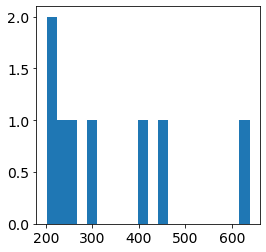

In [1094]:
all_df.loc[(all_df['LifeSquare'] > 200) & (all_df['LifeSquare'] < 1000), 'LifeSquare'].hist(figsize=(4,4), bins=20, grid=False)

In [1095]:
condition = (all_df['LifeSquare'] > 100) & (all_df['Square'] < 80)
all_df[condition].sort_values(by='LifeSquare', ascending=True)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Base,HighIndex,Ecology_23
6332,8961,27,1.0,33.398983,164.153360,6.0,3.0,5.0,1965,0.211401,1,1,9,1892,0,540.0,0,1,1,1,0.60,2
590,14990,23,2.0,48.449873,263.542020,5.0,5.0,6.0,1972,0.075779,1,1,6,1437,3,540.0,0,2,1,1,0.83,2
410,11533,94,2.0,48.713443,303.071094,6.0,5.0,12.0,1974,0.521867,1,1,25,6149,0,540.0,0,0,1,2,0.42,2
4690,2307,102,1.0,40.942518,410.639749,10.0,4.0,4.0,2016,0.238617,1,1,26,3889,6,705.0,3,6,1,1,1.00,2
8437,15886,85,3.0,78.059331,461.463614,10.0,12.0,16.0,1998,0.037178,1,1,52,11217,1,2300.0,1,7,1,1,0.75,2
6977,11602,30,2.0,64.106519,638.163193,10.0,19.0,20.0,2019,0.000078,1,1,22,6398,141,1046.0,3,23,1,1,0.95,2


In [1096]:
all_df.loc[condition, 'LifeSquare'] = all_df.loc[condition, 'LifeSquare'].apply(lambda x: 0.1*x)

In [1097]:
all_df.loc[(all_df['Id'] == 16550), 'LifeSquare'] = all_df.loc[(all_df['Id'] == 16550), 'LifeSquare'].apply(lambda x: 0.01*x)

In [1098]:
all_df[all_df['LifeSquare'] > 150].sort_values(by='LifeSquare', ascending=True)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Base,HighIndex,Ecology_23
5444,14181,62,3.0,156.636577,153.685835,1.0,1.0,3.0,2005,0.072158,1,1,2,629,1,540.0,0,0,0,1,0.33,2
4047,15362,23,1.0,163.286965,161.155275,1.0,3.0,4.0,1977,0.014073,1,1,2,475,0,540.0,0,0,1,1,0.75,2
2603,5621,23,3.0,163.495333,161.504222,12.0,3.0,5.0,1977,0.014073,1,1,2,475,0,540.0,0,0,1,1,0.60,2
8913,2603,30,3.0,162.587886,164.526757,0.0,2.0,3.0,1977,0.000078,1,1,22,6398,141,1046.0,3,23,1,1,0.67,2
2557,16053,17,4.0,168.729035,169.901701,0.0,0.0,4.0,2013,0.093443,1,1,23,4635,5,3300.0,2,4,1,2,0.00,2
3651,5300,30,3.0,169.509941,170.713651,1.0,2.0,2.0,2018,0.000078,1,1,22,6398,141,1046.0,3,23,1,1,1.00,2
1641,11055,151,1.0,174.649522,174.837082,15.0,10.0,12.0,1958,0.236108,1,1,16,3893,27,1145.0,3,10,1,1,0.83,2
9910,16568,27,4.0,200.334539,201.627361,25.0,1.0,2.0,2013,0.041116,1,1,53,14892,4,620.0,1,4,1,1,0.50,2
1981,7917,27,0.0,212.932361,211.231125,0.0,2.0,3.0,2008,0.211401,1,1,9,1892,0,540.0,0,1,1,1,0.67,2
1982,5548,86,5.0,275.645284,233.949309,26.0,12.0,37.0,2011,0.161976,1,0,31,7010,5,4508.0,3,7,1,1,0.32,1


In [1099]:
condition = (all_df['LifeSquare'].isna()) & (all_df['KitchenSquare'] < 33) & (all_df['KitchenSquare'] > 3)
all_df[condition].sort_values(by='LifeSquare', ascending=True)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Base,HighIndex,Ecology_23
152,14141,23,2.0,57.699619,NaN,10.0,1.0,2.0,1977,0.034656,1,1,0,168,0,540.0,0,0,1,1,0.50,2
334,15979,27,1.0,47.426349,NaN,10.0,1.0,9.0,1977,0.072158,1,1,2,629,1,540.0,0,0,0,1,0.11,2
416,10325,1,1.0,37.662346,NaN,10.0,8.0,17.0,2018,0.007122,1,1,1,264,0,540.0,0,1,1,1,0.47,2
448,8119,27,3.0,56.579350,NaN,12.0,24.0,27.0,2014,0.072158,1,1,2,629,1,540.0,0,0,0,1,0.89,2
461,16538,17,3.0,124.601250,NaN,10.0,18.0,20.0,2016,0.093443,1,1,23,4635,5,3300.0,2,4,1,1,0.90,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4645,5252,23,1.0,36.314375,NaN,6.0,12.0,12.0,2015,0.034656,1,1,0,168,0,540.0,0,0,1,2,1.00,2
4671,2896,23,2.0,53.236324,NaN,8.0,6.0,17.0,1977,0.034656,1,1,0,168,0,540.0,0,0,1,2,0.35,2
4752,7432,23,2.0,53.830143,NaN,10.0,1.0,5.0,1977,0.034656,1,1,0,168,0,540.0,0,0,1,2,0.20,2
4845,8165,62,3.0,139.101523,NaN,20.0,3.0,4.0,2015,0.072158,1,1,2,629,1,540.0,0,0,0,2,0.75,2


In [1100]:
all_df.loc[condition, 'LifeSquare'] = all_df.loc[condition, 'Square'] - all_df.loc[condition, 'KitchenSquare'] - 3

In [1101]:
condition = (all_df['LifeSquare'].isna()) & (all_df['KitchenSquare'] < 33)
all_df[condition].sort_values(by='KitchenSquare', ascending=True)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Base,HighIndex,Ecology_23
7,11993,74,2.0,80.312926,NaN,0.0,0.0,14.0,1977,0.075779,1,1,6,1437,3,540.0,0,2,1,1,0.00,2
1719,5196,1,2.0,65.977548,NaN,0.0,13.0,17.0,1977,0.007122,1,1,1,264,0,540.0,0,1,1,2,0.76,2
1704,9366,62,2.0,76.687594,NaN,0.0,0.0,6.0,1977,0.072158,1,1,2,629,1,540.0,0,0,0,2,0.00,2
4366,456,6,0.0,81.491446,NaN,0.0,0.0,4.0,1977,0.243205,1,1,5,1564,0,540.0,0,0,1,1,0.00,2
1648,2759,62,1.0,44.480985,NaN,0.0,0.0,7.0,1977,0.072158,1,1,2,629,1,540.0,0,0,0,2,0.00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5789,7983,1,2.0,63.252299,NaN,1.0,20.0,24.0,1977,0.007122,1,1,1,264,0,540.0,0,1,1,1,0.83,2
5792,334,1,3.0,81.097858,NaN,1.0,9.0,17.0,1977,0.007122,1,1,1,264,0,540.0,0,1,1,1,0.53,2
5760,10354,1,3.0,86.341421,NaN,1.0,22.0,22.0,1977,0.007122,1,1,1,264,0,540.0,0,1,1,1,1.00,2
5560,16680,23,3.0,67.133598,NaN,3.0,2.0,16.0,2015,0.034656,1,1,0,168,0,540.0,0,0,1,1,0.12,2


In [1102]:
all_df.loc[all_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [1103]:
all_df.loc[condition, 'LifeSquare'] = all_df.loc[condition, 'Square'] - all_df.loc[condition, 'KitchenSquare'] - 3

In [1104]:
all_df.loc[all_df['KitchenSquare'] > 600, 'KitchenSquare'] = all_df.loc[all_df['KitchenSquare'] > 600, 'KitchenSquare'].apply(lambda x: 0.01*x)

In [1105]:
condition = (all_df['LifeSquare'].isna()) & (all_df['KitchenSquare'] > 32)
all_df.loc[condition, 'KitchenSquare'] = 3

In [1106]:
all_df.loc[condition, 'LifeSquare'] = all_df.loc[condition, 'Square'] - 6

In [1107]:
condition = (all_df['KitchenSquare'] > 32)
all_df[condition].sort_values(by='KitchenSquare', ascending=True)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Base,HighIndex,Ecology_23
2424,10662,29,1.0,25.956829,17.251768,33.0,5.0,5.0,1973,0.069660,1,1,31,6119,4,620.0,1,2,1,2,1.00,2
625,2249,62,1.0,77.157675,78.281763,34.0,5.0,24.0,2016,0.072158,1,1,2,629,1,540.0,0,0,0,2,0.21,2
5480,15781,10,1.0,35.813564,19.953992,35.0,6.0,14.0,1971,0.282798,1,1,33,8667,2,540.0,0,6,1,1,0.43,2
3379,16781,27,1.0,36.138409,36.710539,36.0,19.0,19.0,2017,0.072158,1,1,2,629,1,540.0,0,0,0,1,1.00,2
1077,9690,27,1.0,40.081042,37.834964,37.0,18.0,19.0,2019,0.211401,1,1,9,1892,0,540.0,0,1,1,1,0.95,2
5849,11624,46,1.0,42.983283,24.224435,37.0,15.0,16.0,1983,0.188784,1,1,31,6137,4,540.0,0,1,1,1,0.94,2
9111,6708,48,1.0,42.069359,22.487739,39.0,1.0,10.0,2010,0.041125,1,1,46,9515,5,620.0,1,10,1,1,0.10,2
3927,6568,78,1.0,46.827201,40.227011,40.0,5.0,32.0,2007,0.219006,1,1,28,6746,3,620.0,1,4,1,2,0.16,2
5816,2271,27,1.0,43.292516,42.835643,40.0,11.0,12.0,2015,0.211401,1,1,9,1892,0,540.0,0,1,1,1,0.92,2
3723,4483,62,1.0,41.951462,45.672140,41.0,13.0,17.0,2018,0.072158,1,1,2,629,1,540.0,0,0,0,2,0.76,2


In [1108]:
all_df.loc[condition, 'KitchenSquare'] = all_df.loc[condition, 'Square'] - all_df.loc[condition, 'LifeSquare'] - 3

In [1109]:
condition = (all_df['KitchenSquare'] < 3)
all_df.loc[condition, 'KitchenSquare'] = 3

In [1110]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 4999
Data columns (total 22 columns):
Id               15000 non-null int64
DistrictId       15000 non-null int64
Rooms            15000 non-null float64
Square           15000 non-null float64
LifeSquare       15000 non-null float64
KitchenSquare    15000 non-null float64
Floor            15000 non-null float64
HouseFloor       15000 non-null float64
HouseYear        15000 non-null int64
Ecology_1        15000 non-null float64
Ecology_2        15000 non-null int64
Ecology_3        15000 non-null int64
Social_1         15000 non-null int64
Social_2         15000 non-null int64
Social_3         15000 non-null int64
Healthcare_1     15000 non-null float64
Helthcare_2      15000 non-null int64
Shops_1          15000 non-null int64
Shops_2          15000 non-null int64
Base             15000 non-null int64
HighIndex        15000 non-null float64
Ecology_23       15000 non-null int64
dtypes: float64(9), int64(13)
memory u

In [1111]:
condition = all_df['Square'] < all_df['LifeSquare']
all_df.loc[condition, 'Square2'] = all_df.loc[condition, 'LifeSquare']

In [1112]:
all_df.loc[condition, 'LifeSquare'] = all_df.loc[condition, 'Square']

In [1113]:
all_df.loc[condition, 'Square'] = all_df.loc[condition, 'Square2']

In [1114]:
all_df = all_df.drop(columns = ['Square2'])

In [1115]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 4999
Data columns (total 22 columns):
Id               15000 non-null int64
DistrictId       15000 non-null int64
Rooms            15000 non-null float64
Square           15000 non-null float64
LifeSquare       15000 non-null float64
KitchenSquare    15000 non-null float64
Floor            15000 non-null float64
HouseFloor       15000 non-null float64
HouseYear        15000 non-null int64
Ecology_1        15000 non-null float64
Ecology_2        15000 non-null int64
Ecology_3        15000 non-null int64
Social_1         15000 non-null int64
Social_2         15000 non-null int64
Social_3         15000 non-null int64
Healthcare_1     15000 non-null float64
Helthcare_2      15000 non-null int64
Shops_1          15000 non-null int64
Shops_2          15000 non-null int64
Base             15000 non-null int64
HighIndex        15000 non-null float64
Ecology_23       15000 non-null int64
dtypes: float64(9), int64(13)
memory u

In [1116]:
all_df['Rooms'].value_counts()

2.0     5910
1.0     5474
3.0     3334
4.0      240
5.0       25
0.0       10
6.0        3
10.0       2
19.0       1
17.0       1
Name: Rooms, dtype: int64

In [1117]:
condition = (all_df['Rooms'] > 0) & (all_df['Rooms'] < 6)
all_df.loc[condition, 'Mean_room_square_onLS'] = all_df.loc[condition, 'LifeSquare'] / all_df.loc[condition, 'Rooms']
all_df.loc[condition, 'Mean_room_square_onS'] = all_df.loc[condition, 'Square'] / all_df.loc[condition, 'Rooms']

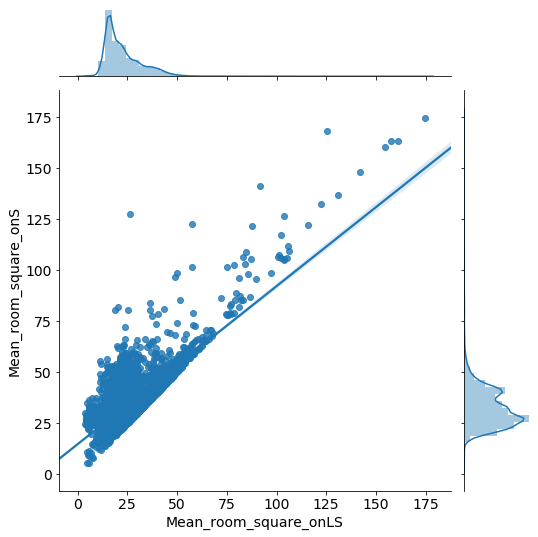

In [1118]:
grid = sns.jointplot(all_df['Mean_room_square_onLS'], all_df['Mean_room_square_onS'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CFAF62F248>,
      dtype=object)

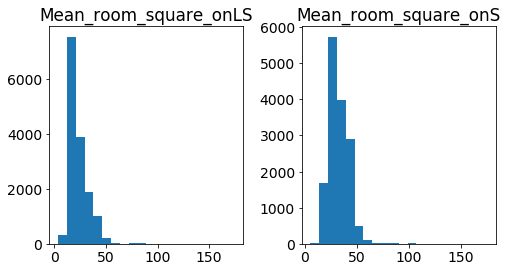

In [1119]:
all_df.loc[condition, ['Mean_room_square_onS', 'Mean_room_square_onLS']].hist(figsize=(8,4), bins=20, grid=False)

In [1120]:
median = all_df.loc[condition, 'Mean_room_square_onS'].median()
median2 = all_df.loc[condition, 'Mean_room_square_onLS'].median()
median

30.89805625372593

In [1121]:
condition = (all_df['Rooms'] < 1) | (all_df['Rooms'] > 5)
all_df.loc[condition, 'Rooms'] = all_df.loc[condition, 'Square'] / median

In [1122]:
all_df['Rooms'].value_counts()

2.000000    5910
1.000000    5474
3.000000    3334
4.000000     240
5.000000      25
3.584375       1
2.825895       1
2.470872       1
1.922915       1
1.911349       1
1.710985       1
3.780956       1
2.840393       1
1.352541       1
4.480142       1
6.891448       1
1.252413       1
2.637430       1
1.359504       1
1.970068       1
1.601509       1
7.231966       1
Name: Rooms, dtype: int64

In [1123]:
all_df.loc[condition, 'Mean_room_square_onS'] = all_df.loc[condition, 'Mean_room_square_onS'].fillna(median)

In [1124]:
all_df.loc[condition, 'Mean_room_square_onLS'] = all_df.loc[condition, 'Mean_room_square_onLS'].fillna(median2)

In [1125]:
all_df['Rooms'] = all_df['Rooms'].apply(lambda x: round(x) if x > 1 else 1)

In [1126]:
all_df['Rooms'].value_counts()

2    5916
1    5477
3    3337
4     243
5      25
7       2
Name: Rooms, dtype: int64

In [1127]:
all_df['UsefulSquare'] = all_df['Square'] / all_df['LifeSquare']

In [1128]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 4999
Data columns (total 25 columns):
Id                       15000 non-null int64
DistrictId               15000 non-null int64
Rooms                    15000 non-null int64
Square                   15000 non-null float64
LifeSquare               15000 non-null float64
KitchenSquare            15000 non-null float64
Floor                    15000 non-null float64
HouseFloor               15000 non-null float64
HouseYear                15000 non-null int64
Ecology_1                15000 non-null float64
Ecology_2                15000 non-null int64
Ecology_3                15000 non-null int64
Social_1                 15000 non-null int64
Social_2                 15000 non-null int64
Social_3                 15000 non-null int64
Healthcare_1             15000 non-null float64
Helthcare_2              15000 non-null int64
Shops_1                  15000 non-null int64
Shops_2                  15000 non-null int64
Base

In [1129]:
all_df['Mean_room_square_onLS'] = all_df['Mean_room_square_onLS'].apply(lambda x: round(x,4))
all_df['Mean_room_square_onS'] = all_df['Mean_room_square_onS'].apply(lambda x: round(x,4))
all_df['UsefulSquare'] = all_df['UsefulSquare'].apply(lambda x: round(x,4))

In [1256]:
all_df.to_csv(data_folder / 'all_df.csv', index=False, encoding='utf-8')

In [1130]:
pd.set_option('display.max_columns', None)
all_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Base,HighIndex,Ecology_23,Mean_room_square_onLS,Mean_room_square_onS,UsefulSquare
0,14038,35,2,47.981561,29.442751,6.0,7.0,9.0,1969,0.089040,1,1,33,7976,5,540.0,0,11,1,1,0.78,2,14.7214,23.9908,1.6297
1,15053,41,3,65.683640,40.049543,8.0,7.0,9.0,1978,0.000070,1,1,46,10309,1,240.0,1,16,1,1,0.78,2,13.3498,21.8945,1.6401
2,4765,53,2,44.947953,29.197612,3.0,8.0,12.0,1968,0.049637,1,1,34,7759,0,229.0,1,3,1,1,0.67,2,14.5988,22.4740,1.5394
3,5809,58,2,53.352981,52.731512,9.0,8.0,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1,1,0.47,2,26.3658,26.6765,1.0118
4,10783,99,1,39.649192,23.776169,7.0,11.0,12.0,1976,0.012339,1,1,35,5776,1,2078.0,2,4,1,1,0.92,2,23.7762,39.6492,1.6676


In [1236]:
list1 = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'Floor', 'HouseFloor', 'HouseYear', \
         'Ecology_1', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2']

In [1237]:
x_train_new = all_df[all_df['Base']==1]

In [1238]:
x_test_new = all_df[all_df['Base']==2]

In [1239]:
x_train1 = x_train_new[list1]

In [1240]:
x_test1 = x_test_new[list1]

In [1241]:
x_train1.head()

,DistrictId,Rooms,Square,LifeSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_3,Helthcare_2,Shops_1,Shops_2
0,35,2,47.981561,29.442751,7.0,9.0,1969,0.089040,5,0,11,1
1,41,3,65.683640,40.049543,7.0,9.0,1978,0.000070,1,1,16,1
2,53,2,44.947953,29.197612,8.0,12.0,1968,0.049637,0,1,3,1
3,58,2,53.352981,52.731512,8.0,17.0,1977,0.437885,3,0,5,1
4,99,1,39.649192,23.776169,11.0,12.0,1976,0.012339,1,2,4,1


In [1242]:
x_train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 12 columns):
DistrictId     10000 non-null int64
Rooms          10000 non-null int64
Square         10000 non-null float64
LifeSquare     10000 non-null float64
Floor          10000 non-null float64
HouseFloor     10000 non-null float64
HouseYear      10000 non-null int64
Ecology_1      10000 non-null float64
Social_3       10000 non-null int64
Helthcare_2    10000 non-null int64
Shops_1        10000 non-null int64
Shops_2        10000 non-null int64
dtypes: float64(5), int64(7)
memory usage: 1015.6 KB


In [1243]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

R2:	0.529
RMSE:	63716.566
MSE:	4059800771.521


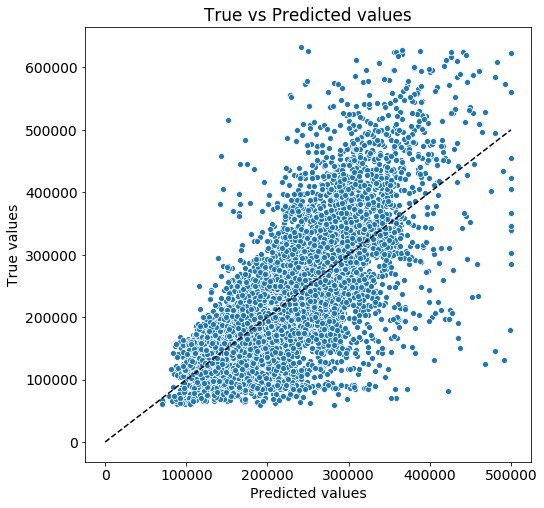

In [1244]:
lr_model = LinearRegression()
lr_model.fit(x_train1, y_train)

y_train_preds = lr_model.predict(x_train1)
# Постпрецессинг
y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500000)

evaluate_preds(y_train, y_train_preds)

R2:	0.728
RMSE:	48436.949
MSE:	2346138017.715


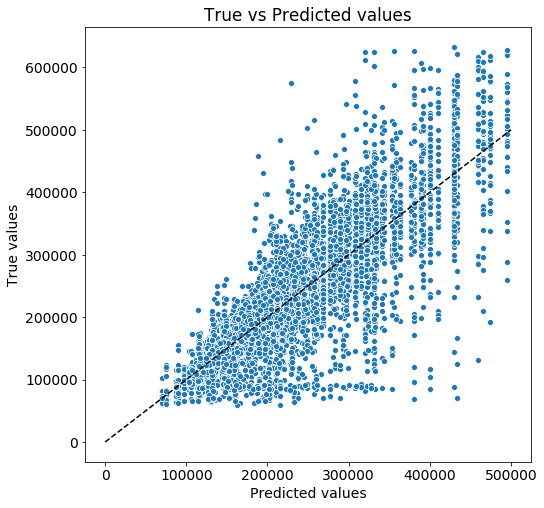

In [1245]:
dt_model = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=20, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42)
dt_model.fit(x_train1, y_train)

y_train_preds = dt_model.predict(x_train1)
evaluate_preds(y_train, y_train_preds)

R2:	0.738
RMSE:	47511.666
MSE:	2257358437.559


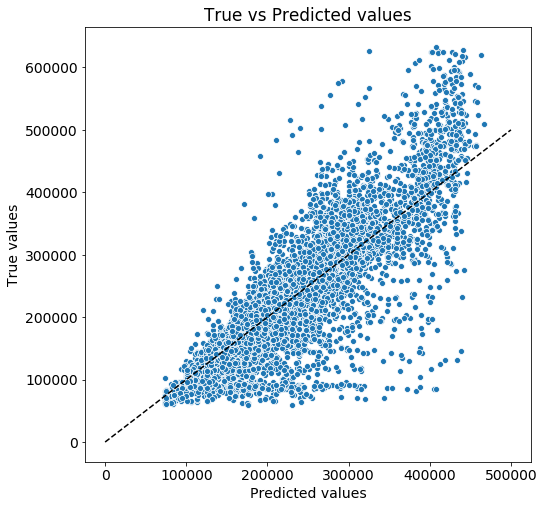

In [1246]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=20, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                
                                n_estimators=100  # кол-во деревьев
                                )

rf_model.fit(x_train1, y_train)
y_train_preds = rf_model.predict(x_train1)
evaluate_preds(y_train, y_train_preds)

In [1247]:
lgb_model = LGBMRegressor(criterion='mse',
                            min_samples_leaf=10,
                            random_state=42 #,
                         
                         # n_estimators=100,
                         # max_depth=7
                         
                         )

In [1248]:
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(lgb_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True), 
                  n_jobs=-1  # Кол-во потоков 
                 )
gs.fit(x_train1, y_train)  # НА TRAIN!

GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0, criterion='mse',
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001,
                                     min_samples_leaf=10, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=42,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [

In [1249]:
res = pd.DataFrame(gs.cv_results_)
res.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.087395,0.003783,0.014087,0.000807,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.680134,0.646699,0.672468,0.692017,0.667335,0.671731,0.015024,16
1,0.136894,0.006549,0.020336,0.001472,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.714976,0.667846,0.707069,0.730108,0.700277,0.704055,0.020652,15


In [1250]:
gs.best_params_

{'max_depth': 7, 'n_estimators': 200}

In [1251]:
gs.best_score_

0.7437832661249831

R2:	0.876
RMSE:	32709.356
MSE:	1069901994.59


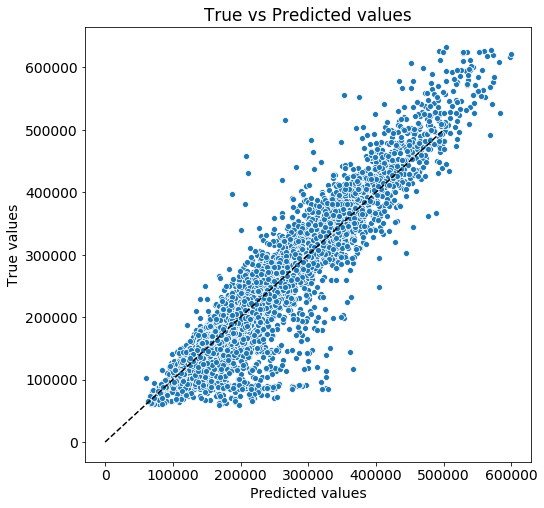

In [1252]:
final_model = LGBMRegressor(criterion='mse',
                            max_depth=7,
                            min_samples_leaf=10,
                            random_state=42,  

                            n_estimators=200)

final_model.fit(x_train1, y_train)

y_train_preds = final_model.predict(x_train1)
evaluate_preds(y_train, y_train_preds)

In [1253]:
feature_importances = pd.DataFrame(zip(x_train1.columns, 
                                       final_model.feature_importances_ / final_model.feature_importances_.sum()), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [1254]:
feature_importances.head(20).sort_values(by='importance')

,feature_name,importance
11,Shops_2,0.003417
1,Rooms,0.021043
9,Helthcare_2,0.029317
10,Shops_1,0.050360
5,HouseFloor,0.077878
4,Floor,0.079496
8,Social_3,0.080216
3,LifeSquare,0.108094
7,Ecology_1,0.116367
6,HouseYear,0.122842


R2:	0.881
RMSE:	31977.781
MSE:	1022578452.687


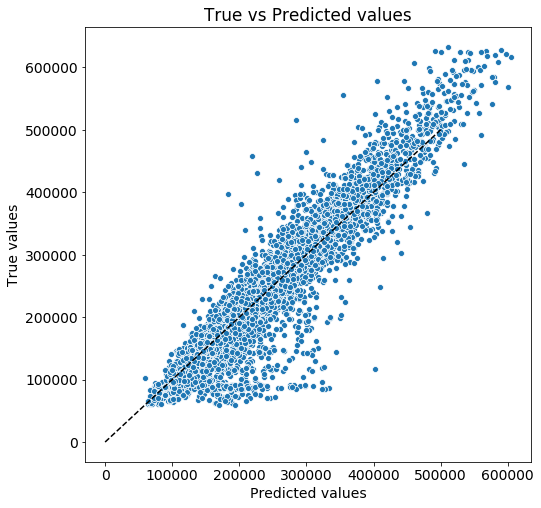

In [1255]:
final_model3 = LGBMRegressor(criterion='mse',
                            max_depth=5,
                            min_samples_leaf=10,
                            random_state=42,  

                            n_estimators=400)

final_model3.fit(x_train1, y_train)

y_train_preds = final_model3.predict(x_train1)
evaluate_preds(y_train, y_train_preds)

In [1187]:
#with open(data_folder / 'final_model.pkl', 'wb') as file:
 #   pickle.dump(final_model3, file)

In [ ]:
with open(data_folder / 'final_model.pkl', 'rb') as file:
    my_model = pickle.load(file)
    
my_model

In [1227]:
y_test_preds = final_model3.predict(x_test1)

In [1233]:
x_test_id = x_test.Id

In [1234]:
final_df = pd.DataFrame({'Id': x_test_id, 'Price': y_test_preds})
final_df.head()

,Id,Price
0,725,149502.514476
1,15856,216726.546172
2,5480,293745.615056
3,15664,336567.033812
4,14275,134604.447221


In [1235]:
final_df.to_csv(data_folder / 'result_v5.csv', index=False)